# Comprehensive LoRA Analysis for Whisper Audio Classification


In [1]:
import torch
from datasets import load_dataset, concatenate_datasets
from transformers import WhisperForAudioClassification, WhisperFeatureExtractor
from nnsight import NNsight
from peft import PeftModel, LoraConfig, get_peft_model
import os
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import analysis_utils
import torch.nn as nn
from sklearn.manifold import TSNE
from collections import defaultdict
from sklearn.metrics.pairwise import rbf_kernel

plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

import warnings
warnings.filterwarnings('ignore')

## Configuration

In [2]:
# Experiment configuration
fold_idx = 1
model_name = 'openai/whisper-large-v2'
id2label = {0: "anger", 1: "happiness", 2: "neutral", 3: "sadness"}
label2id = {v: k for k, v in id2label.items()}

# Device configuration
device1 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device2 = torch.device("cuda:1" if torch.cuda.device_count() > 1 else device1)
device3 = torch.device("cuda:2" if torch.cuda.device_count() > 2 else device1)

print(f"Using devices: {device1}, {device2}, {device3}")

Using devices: cuda:0, cuda:1, cuda:2


## Data Preparation

In [3]:
def select_balanced_samples(dataset, num_per_class=10, label_column='labels', seed=42, return_indices=False):
    ds = dataset.shuffle(seed=seed)
    labels_all = ds[label_column]
    unique_labels = sorted(set(labels_all))
    counts = {lbl: 0 for lbl in unique_labels}
    selected_indices = []

    for idx, lbl in enumerate(labels_all):
        if counts[lbl] < num_per_class:
            selected_indices.append(idx)
            counts[lbl] += 1
        if all(counts[l] >= num_per_class for l in unique_labels):
            break

    selected_dataset = ds.select(selected_indices)
    if return_indices:
        return selected_dataset, counts, selected_indices
    return selected_dataset, counts

def prepare_data(examples):
    audio_arrays = [item['array'] for item in examples['audio']]
    labels = examples['label']
    speakers = [path.split('/')[-1].split('_')[0] for path in [item['path'] for item in examples['audio']]]
    return {
        "audio": audio_arrays,
        "labels": labels,
        "speaker": speakers
    }

print("Loading IEMOCAP dataset...")
ds = load_dataset("Zahra99/IEMOCAP_Audio")
dataset = concatenate_datasets([ds['session1'], ds['session2'], ds['session3'], ds['session4'], ds['session5']])
del ds

dataset = dataset.map(prepare_data, batched=True, remove_columns=dataset.column_names, num_proc=4)
speakers_array = np.array(dataset['speaker'])
all_speaker = sorted(list(set(dataset['speaker'])))
test_speaker = all_speaker[fold_idx-1]
test_indices = np.where(speakers_array == test_speaker)[0]
test_data = dataset.select(test_indices)

# Prepare train data for gradient analysis
train_speaker = [speaker for speaker in all_speaker if speaker != test_speaker]
train_indices = np.where(np.isin(speakers_array, train_speaker))[0]
train_data = dataset.select(train_indices)
del dataset

# Select balanced samples
test_samples, counts_test = select_balanced_samples(test_data, num_per_class=10, label_column='labels', seed=42)
train_samples, counts_train = select_balanced_samples(train_data, num_per_class=10, label_column='labels', seed=42)
del train_data

print(f"Test samples: {len(test_data)}, Train samples for gradient analysis: {len(train_samples)}")
print(f"Test speaker: {test_speaker}")

Loading IEMOCAP dataset...
Test samples: 507, Train samples for gradient analysis: 40
Test speaker: Ses01F


In [4]:
processor = WhisperFeatureExtractor.from_pretrained(model_name)

In [5]:
def get_model(save_path):
    checkpoint = os.path.join(
        save_path,
        [d for d in os.listdir(save_path) if os.path.isdir(os.path.join(save_path, d)) and d.startswith('checkpoint-')][0]
    )
    model = WhisperForAudioClassification.from_pretrained(
        checkpoint,
        num_labels=4,
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True
    )
    model.eval()
    return NNsight(model)

def create_random_lora_model(target_modules=["v_proj"], r=32):
    base_model = WhisperForAudioClassification.from_pretrained(
        model_name,
        num_labels=4,
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True
    )
    lora_config = LoraConfig(
        r=r,
        lora_alpha=64,
        target_modules=target_modules,
        lora_dropout=0.1,
        bias="none",
        modules_to_save=["projector", "classifier"],
    )
    random_model = get_peft_model(base_model, lora_config)

    for name, param in random_model.named_parameters():
        if 'lora' in name and param.requires_grad:
            if 'weight' in name:
                nn.init.normal_(param, mean=0.0, std=0.02)
            elif 'bias' in name:
                nn.init.zeros_(param)
    return random_model

# Experiment 1: LoRA Contribution Analysis

This experiment analyzes the contribution of attention and MLP components across different layers in LoRA-adapted and frozen encoder models.

In [6]:
print("Loading LoRA and frozen models...")
lora_save_path = f"./{model_name}-lora/fold{fold_idx}"
frozen_save_path = f"./frozen-encoder/{model_name.split('/')[-1]}/fold{fold_idx}"

lora_model = get_model(lora_save_path)
frozen_model = get_model(frozen_save_path)

lora_model.to(device1)
frozen_model.to(device2)

num_layers = lora_model.config.encoder_layers
print(f"Number of encoder layers: {num_layers}")

Loading LoRA and frozen models...


Some weights of WhisperForAudioClassification were not initialized from the model checkpoint at openai/whisper-large-v2 and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of encoder layers: 32


In [7]:
print("Analyzing LoRA model contributions...")
rc_att, rc_mlp, rc_layer, att_cos, mlp_cos, layer_cos = analysis_utils.analyze_norms(
    lora_model, test_data, processor, len(test_data)
)

print("Analyzing frozen model contributions...")
rc_att_frozen, rc_mlp_frozen, rc_layer_frozen, att_cos_frozen, mlp_cos_frozen, layer_cos_frozen = analysis_utils.analyze_norms(
    frozen_model, test_data, processor, len(test_data)
)

Analyzing LoRA model contributions...


100%|██████████| 507/507 [04:18<00:00,  1.96it/s]


Analyzing frozen model contributions...


100%|██████████| 507/507 [04:11<00:00,  2.02it/s]


Plotting LoRA model results...


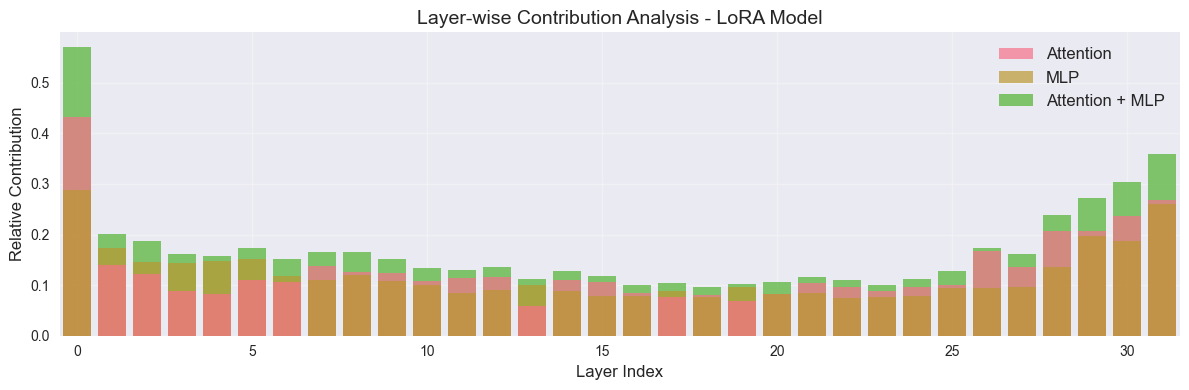

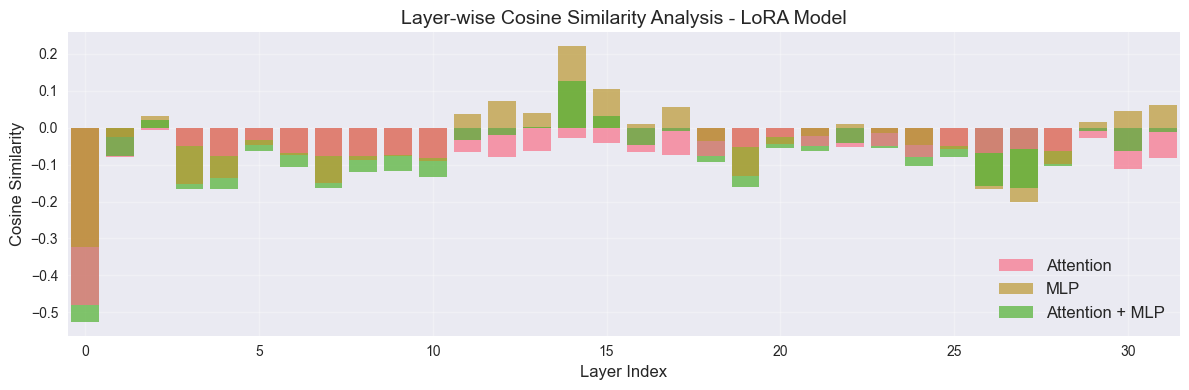

Plotting frozen model results...


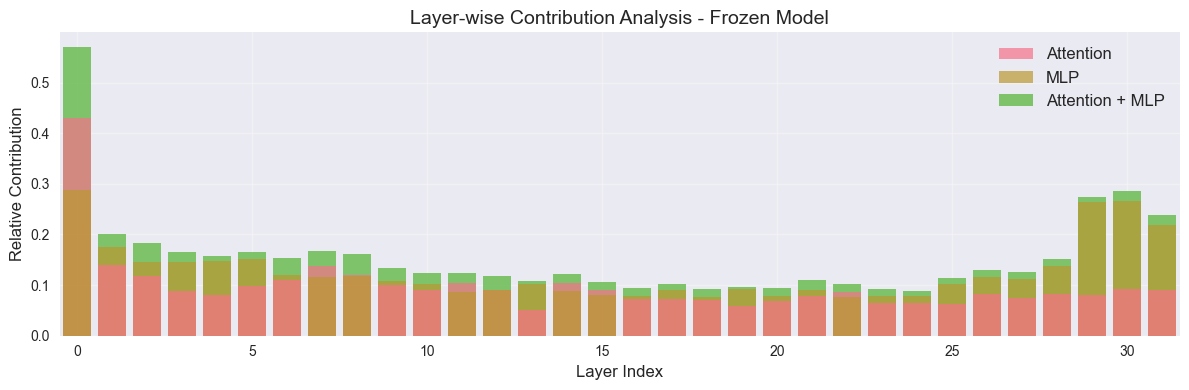

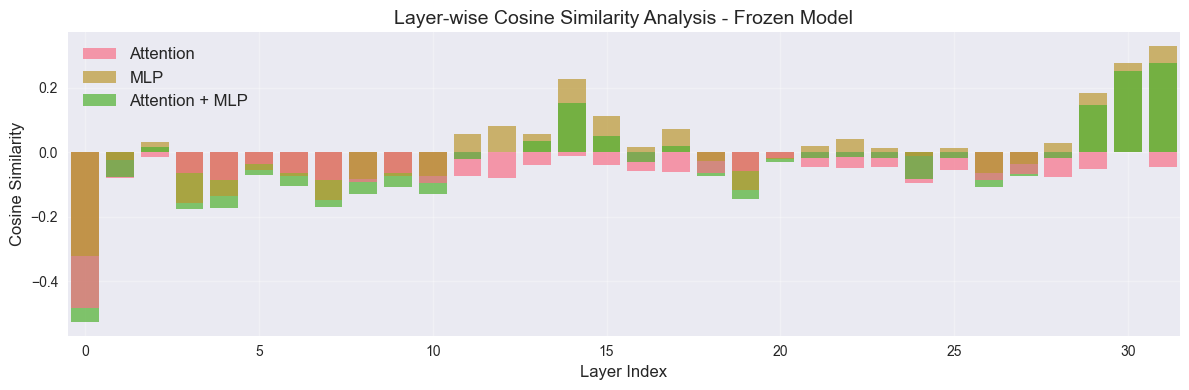

In [8]:
def sort_zorder(bars):
    for group in zip(*[container for container in bars]):
        z = len(group)
        for bar in sorted(group, key=lambda b: abs(b.get_height())):
            bar.set_zorder(z)
            z -= 1

def plot_residual_stats(att, mlp, layer, title_suffix=""):
    plt.figure(figsize=(12, 4))
    bars = []
    bars.append(plt.bar([x for x in range(num_layers)], att.float().cpu().numpy(), 
                        label="Attention", width=0.8, alpha=0.7))
    bars.append(plt.bar([x for x in range(num_layers)], mlp.float().cpu().numpy(), 
                        label="MLP", width=0.8, alpha=0.7))
    bars.append(plt.bar([x for x in range(num_layers)], layer.float().cpu().numpy(), 
                        label="Attention + MLP", width=0.8, alpha=0.7))
    
    plt.legend(fontsize=12)
    sort_zorder(bars)
    plt.xlim(-0.5, num_layers-0.5)
    plt.xlabel("Layer Index", fontsize=12)
    plt.ylabel("Relative Contribution", fontsize=12)
    plt.title(f"Layer-wise Contribution Analysis{title_suffix}", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_cosine_similarity(att_cos, mlp_cos, layer_cos, title_suffix=""):
    plt.figure(figsize=(12, 4))
    bars = []
    bars.append(plt.bar([x for x in range(num_layers)], att_cos.float().cpu().numpy(), 
                        label="Attention", width=0.8, alpha=0.7))
    bars.append(plt.bar([x for x in range(num_layers)], mlp_cos.float().cpu().numpy(), 
                        label="MLP", width=0.8, alpha=0.7))
    bars.append(plt.bar([x for x in range(num_layers)], layer_cos.float().cpu().numpy(), 
                        label="Attention + MLP", width=0.8, alpha=0.7))
    
    plt.legend(fontsize=12)
    sort_zorder(bars)
    plt.xlim(-0.5, num_layers-0.5)
    plt.xlabel("Layer Index", fontsize=12)
    plt.ylabel("Cosine Similarity", fontsize=12)
    plt.title(f"Layer-wise Cosine Similarity Analysis{title_suffix}", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print("Plotting LoRA model results...")
plot_residual_stats(rc_att, rc_mlp, rc_layer, " - LoRA Model")
plot_cosine_similarity(att_cos, mlp_cos, layer_cos, " - LoRA Model")

print("Plotting frozen model results...")
plot_residual_stats(rc_att_frozen, rc_mlp_frozen, rc_layer_frozen, " - Frozen Model")
plot_cosine_similarity(att_cos_frozen, mlp_cos_frozen, layer_cos_frozen, " - Frozen Model")

Plotting LoRA - frozen model results...


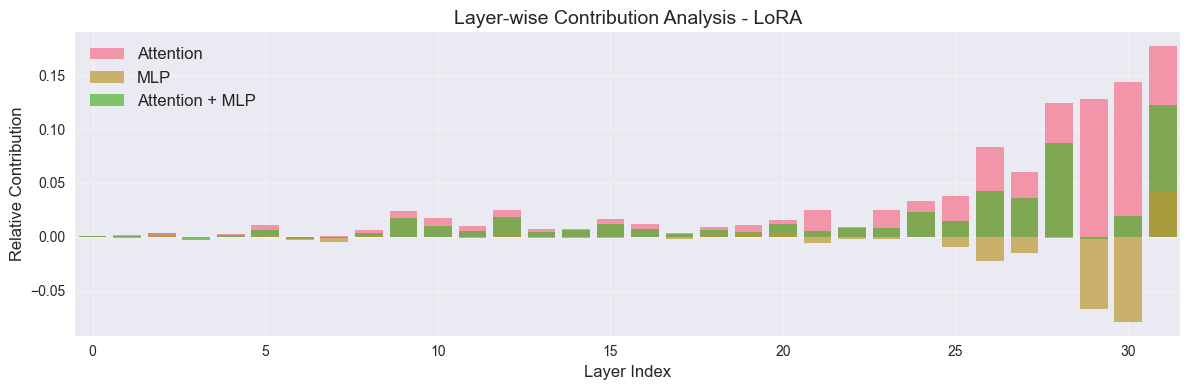

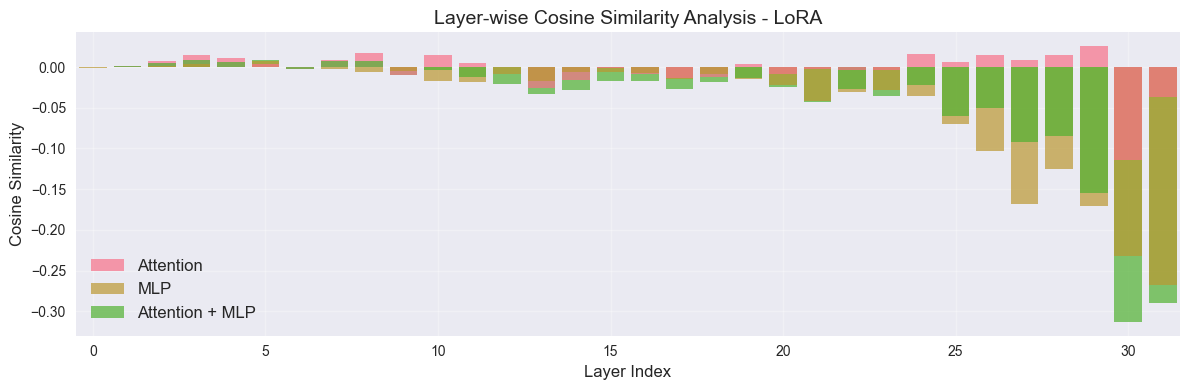

In [9]:
print("Plotting LoRA - frozen model results...")
plot_residual_stats(rc_att-rc_att_frozen, rc_mlp-rc_mlp_frozen, rc_layer-rc_layer_frozen, " - LoRA")
plot_cosine_similarity(att_cos-att_cos_frozen, mlp_cos-mlp_cos_frozen, layer_cos-layer_cos_frozen, " - LoRA")


# Experiment 2: Logit-len

In [10]:
lora_logit_len = analysis_utils.logit_lens(lora_model,test_data)
frozen_logit_len = analysis_utils.logit_lens(frozen_model,test_data)

100%|██████████| 507/507 [01:40<00:00,  5.03it/s]


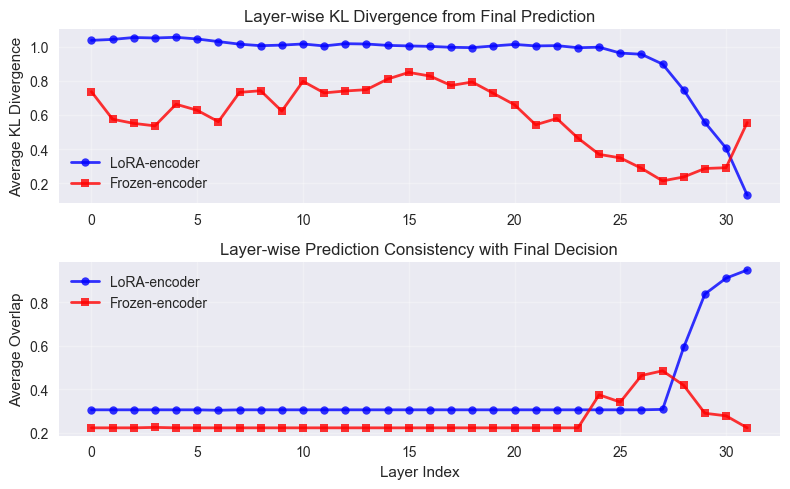

In [11]:
def plot_kl(lora_logit_len, frozen_logit_len):
    avg_kl_divs_lora = lora_logit_len['avg_kl_divs']
    avg_kl_divs_frozen = frozen_logit_len['avg_kl_divs']
    avg_overlaps_lora = lora_logit_len['avg_overlaps']
    avg_overlaps_frozen = frozen_logit_len['avg_overlaps']
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5))
    layers = range(len(avg_kl_divs_lora))
    ax1.plot(layers, avg_kl_divs_lora, 'b-o', linewidth=2, markersize=6, label='LoRA-encoder', alpha=0.8)        
    ax1.plot(layers, avg_kl_divs_frozen, 'r-s', linewidth=2, markersize=6, label='Frozen-encoder', alpha=0.8)
    ax1.set_ylabel('Average KL Divergence')      
    ax1.set_title('Layer-wise KL Divergence from Final Prediction')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    ax2.plot(layers, avg_overlaps_lora, 'b-o', linewidth=2, markersize=6, label='LoRA-encoder', alpha=0.8)        
    ax2.plot(layers, avg_overlaps_frozen, 'r-s', linewidth=2, markersize=6, label='Frozen-encoder', alpha=0.8)
    ax2.set_xlabel('Layer Index')
    ax2.set_ylabel('Average Overlap')      
    ax2.set_title('Layer-wise Prediction Consistency with Final Decision')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
plot_kl(lora_logit_len,frozen_logit_len)

# Experiment 3: Rank Comparison with t-SNE

This experiment compares different LoRA ranks (8, 32, 64) using t-SNE visualization of the rank space activations.

In [12]:
print("Loading models with different LoRA ranks...")
lora64_save_path = f"./ablation-large-v2/rank64_modulesv_proj/fold{fold_idx}"
lora32_save_path = f"./ablation-large-v2/rank32_modulesv_proj/fold{fold_idx}"
lora8_save_path = f"./ablation-large-v2/rank8_modulesv_proj/fold{fold_idx}"

lora64_model = get_model(lora64_save_path)
lora32_model = get_model(lora32_save_path)
lora8_model = get_model(lora8_save_path)

lora8_model.to(device1)
lora32_model.to(device2)
lora64_model.to(device3)

Loading models with different LoRA ranks...


Some weights of WhisperForAudioClassification were not initialized from the model checkpoint at openai/whisper-large-v2 and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of WhisperForAudioClassification were not initialized from the model checkpoint at openai/whisper-large-v2 and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of WhisperForAudioClassification were not initialized from the model checkpoint at openai/whisper-large-v2 and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and 

WhisperForAudioClassification(
  (encoder): WhisperEncoder(
    (conv1): Conv1d(80, 1280, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(1280, 1280, kernel_size=(3,), stride=(2,), padding=(1,))
    (embed_positions): Embedding(1500, 1280)
    (layers): ModuleList(
      (0-31): 32 x WhisperEncoderLayer(
        (self_attn): WhisperAttention(
          (k_proj): Linear(in_features=1280, out_features=1280, bias=False)
          (v_proj): Linear(
            (base_layer): Linear(in_features=1280, out_features=1280, bias=True)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.1, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=1280, out_features=64, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=64, out_features=1280, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterD

In [13]:
# Define layers for analysis (selected layers)
selected_layers = [0, 7, 15, 23, 31]
lora_layers = [f"encoder.layers.{i}.self_attn.v_proj" for i in selected_layers]

def get_rank_activations(nmodel, test_data, lora_layers):
    device = nmodel.device
    all_rank = []
    
    for sample_idx, sample in tqdm(enumerate(test_data), desc="Extracting activations"):
        input_features = processor(
            sample['audio'],
            sampling_rate=16000,
            return_tensors="pt"
        ).input_features.to(device)
        
        rank = []
        with torch.no_grad():
            with nmodel.trace(input_features) as tracer:
                for layer_name in lora_layers:
                    activation = nmodel.get(f'{layer_name}.lora_A.default.output').clone().detach().cpu().save()
                    rank.append(activation)
        
        rank = torch.stack(rank, dim=0)
        all_rank.append(rank)
    
    return torch.stack(all_rank, dim=0)

# Extract rank activations
print("Extracting rank-8 activations...")
lora8_rank = get_rank_activations(lora8_model, test_data, lora_layers)

print("Extracting rank-32 activations...")
lora32_rank = get_rank_activations(lora32_model, test_data, lora_layers)

print("Extracting rank-64 activations...")
lora64_rank = get_rank_activations(lora64_model, test_data, lora_layers)

print(f"Rank shapes - 8: {lora8_rank.shape}, 32: {lora32_rank.shape}, 64: {lora64_rank.shape}")

Extracting rank-8 activations...


Extracting activations: 507it [01:38,  5.12it/s]


Extracting rank-32 activations...


Extracting activations: 507it [01:48,  4.68it/s]


Extracting rank-64 activations...


Extracting activations: 507it [01:45,  4.79it/s]


Rank shapes - 8: torch.Size([507, 5, 1, 1500, 8]), 32: torch.Size([507, 5, 1, 1500, 32]), 64: torch.Size([507, 5, 1, 1500, 64])


In [14]:
selected_layers = [0, 7, 15, 23, 31]
lora_layers = [f"encoder.layers.{i}.self_attn.v_proj" for i in selected_layers]

def get_rank_activations(nmodel, test_data, lora_layers):
    device = nmodel.device
    all_rank = []
    
    for sample_idx, sample in tqdm(enumerate(test_data), desc="Extracting activations"):
        input_features = processor(
            sample['audio'],
            sampling_rate=16000,
            return_tensors="pt"
        ).input_features.to(device)
        
        rank = []
        with torch.no_grad():
            with nmodel.trace(input_features) as tracer:
                for layer_name in lora_layers:
                    activation = nmodel.get(f'{layer_name}.lora_A.default.output').clone().detach().cpu().save()
                    rank.append(activation)
        
        rank = torch.stack(rank, dim=0)
        all_rank.append(rank)
    
    return torch.stack(all_rank, dim=0)

print("Extracting rank-8 activations...")
lora8_rank = get_rank_activations(lora8_model, test_data, lora_layers)

print("Extracting rank-32 activations...")
lora32_rank = get_rank_activations(lora32_model, test_data, lora_layers)

print("Extracting rank-64 activations...")
lora64_rank = get_rank_activations(lora64_model, test_data, lora_layers)

print(f"Rank shapes - 8: {lora8_rank.shape}, 32: {lora32_rank.shape}, 64: {lora64_rank.shape}")

Extracting rank-8 activations...


Extracting activations: 507it [01:43,  4.88it/s]


Extracting rank-32 activations...


Extracting activations: 507it [01:48,  4.68it/s]


Extracting rank-64 activations...


Extracting activations: 507it [01:42,  4.93it/s]


Rank shapes - 8: torch.Size([507, 5, 1, 1500, 8]), 32: torch.Size([507, 5, 1, 1500, 32]), 64: torch.Size([507, 5, 1, 1500, 64])


Performing t-SNE analysis...
Processing Rank-8...
  Processing Layer 0...
  Processing Layer 7...
  Processing Layer 15...
  Processing Layer 23...
  Processing Layer 31...
Processing Rank-32...
  Processing Layer 0...
  Processing Layer 7...
  Processing Layer 15...
  Processing Layer 23...
  Processing Layer 31...
Processing Rank-64...
  Processing Layer 0...
  Processing Layer 7...
  Processing Layer 15...
  Processing Layer 23...
  Processing Layer 31...


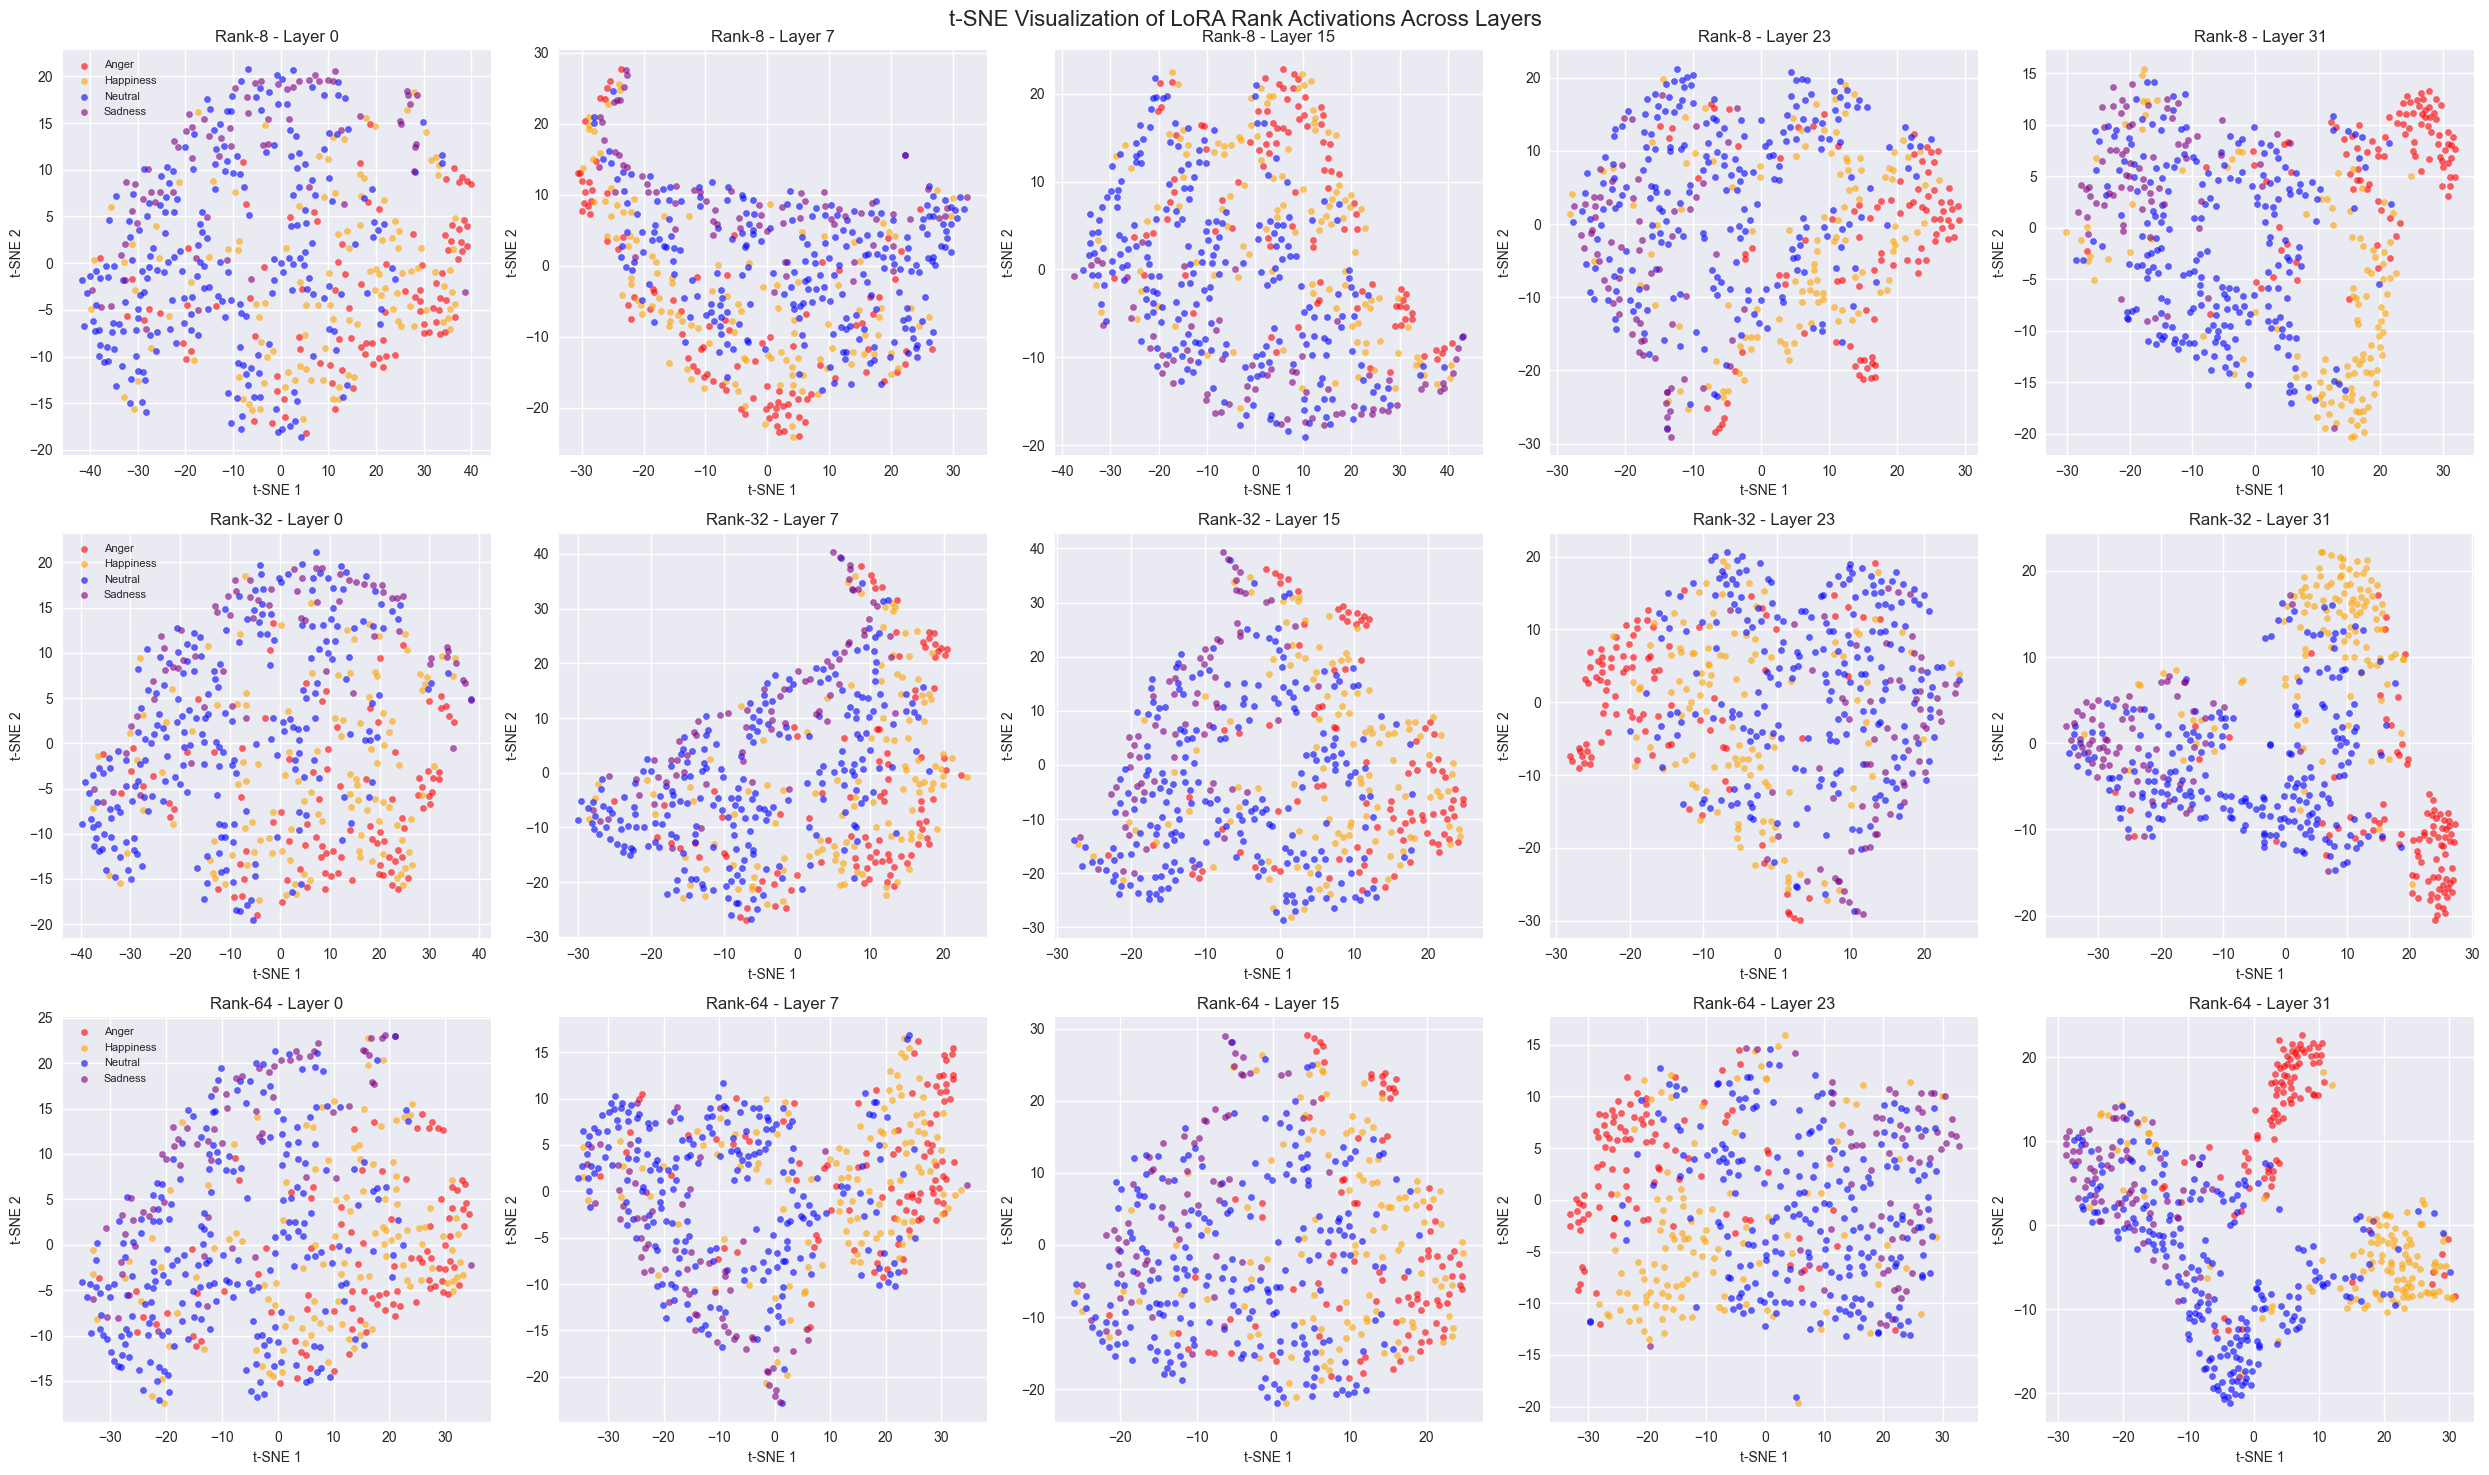

t-SNE analysis completed and saved as 'lora_tsne_comparison.png'


In [15]:

def perform_tsne_analysis(rank_data_dict, test_data, selected_layers):
    print("Performing t-SNE analysis...")
    

    labels = [sample['labels'] for sample in test_data]
    emotion_names = ['Anger', 'Happiness', 'Neutral', 'Sadness']
    colors = ['red', 'orange', 'blue', 'purple']
    
    fig, axes = plt.subplots(3, 5, figsize=(25, 15))
    fig.suptitle('t-SNE Visualization of LoRA Rank Activations Across Layers', fontsize=16)
    
    rank_names = ['Rank-8', 'Rank-32', 'Rank-64']
    
    for rank_idx, (rank_name, rank_data) in enumerate(rank_data_dict.items()):
        print(f"Processing {rank_name}...")
        
        for layer_idx, layer_num in enumerate(selected_layers):
            print(f"  Processing Layer {layer_num}...")
            

            layer_data = rank_data[:, layer_idx, 0, :, :].numpy()  # [samples, seq_len, rank]

            layer_features_flat = layer_data.reshape(layer_data.shape[0], -1)  # [samples, seq_len*rank]
            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            layer_features_scaled = scaler.fit_transform(layer_features_flat)
            
            tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
            tsne_result = tsne.fit_transform(layer_features_scaled)
            
            ax = axes[rank_idx, layer_idx]
            
            for emotion_idx, (emotion_name, color) in enumerate(zip(emotion_names, colors)):
                mask = np.array(labels) == emotion_idx
                ax.scatter(tsne_result[mask, 0], tsne_result[mask, 1], 
                          c=color, label=emotion_name, alpha=0.6, s=20)
            
            ax.set_title(f'{rank_name} - Layer {layer_num}', fontsize=12)
            ax.set_xlabel('t-SNE 1', fontsize=10)
            ax.set_ylabel('t-SNE 2', fontsize=10)
            
            if layer_idx == 0:
                ax.legend(fontsize=8)
    
    plt.tight_layout()
    plt.savefig('lora_tsne_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("t-SNE analysis completed and saved as 'lora_tsne_comparison.png'")

# Perform t-SNE analysis
rank_data_dict = {
    'Rank-8': lora8_rank,
    'Rank-32': lora32_rank,
    'Rank-64': lora64_rank
}

perform_tsne_analysis(rank_data_dict, test_data, selected_layers)

# Experiment 3: Gradient Analysis

This experiment compares gradients between learned LoRA weights and randomly initialized LoRA weights to understand learning dynamics.

In [16]:
print("Setting up gradient analysis models...")
lora_save_path = f"./ablation-large-v2/rank32_modulesv_proj/fold{fold_idx}"
learned_model = get_model(lora_save_path)
random_model = NNsight(create_random_lora_model(target_modules=["v_proj"], r=32))

# Move to devices
learned_model.to(device1)
random_model.to(device2)

gradient_lora_layers = [f"encoder.layers.{i}.self_attn.v_proj" 
                       for i in range(learned_model.config.encoder_layers)]

for param in random_model.parameters():
    param.requires_grad = False
for param in learned_model.parameters():
    param.requires_grad = False

for layer in gradient_lora_layers:
    learned_model.get(f'{layer}.lora_A.default.weight').requires_grad = True
    learned_model.get(f'{layer}.lora_B.default.weight').requires_grad = True
    random_model.get(f'{layer}.lora_A.default.weight').requires_grad = True
    random_model.get(f'{layer}.lora_B.default.weight').requires_grad = True

print(f"Gradient analysis setup complete for {len(gradient_lora_layers)} layers")

Setting up gradient analysis models...


Some weights of WhisperForAudioClassification were not initialized from the model checkpoint at openai/whisper-large-v2 and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of WhisperForAudioClassification were not initialized from the model checkpoint at openai/whisper-large-v2 and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Gradient analysis setup complete for 32 layers


In [17]:
def get_gradient_batch(nmodel, samples_list, lora_layers, batch_size=1):
    device = nmodel.device
    all_rank = {layer: [] for layer in lora_layers}
    all_lora = {layer: [] for layer in lora_layers}
    all_rank_grad = {layer: [] for layer in lora_layers}
    all_lora_grad = {layer: [] for layer in lora_layers}
    all_outputs = []
    
    num_samples = len(samples_list)
    for i in tqdm(range(0, num_samples, batch_size), desc="Computing gradients"):
        batch_samples = samples_list.select(range(i, min(i + batch_size, num_samples)))
        
        input_audios = [sample['audio'] for sample in batch_samples]
        labels = torch.tensor([sample['labels'] for sample in batch_samples]).to(device)
        input_features = processor(input_audios, sampling_rate=16000, return_tensors="pt").input_features.to(device)
        
        rank, lora = {}, {}
        
        with nmodel.trace(input_features) as tracer:
            for layer_name in lora_layers:
                nmodel.get(f'{layer_name}.lora_A.default.output').retain_grad()
                rank[layer_name] = nmodel.get(f'{layer_name}.lora_A.default.output').save()
                nmodel.get(f'{layer_name}.lora_B.default.output').retain_grad()
                lora[layer_name] = nmodel.get(f'{layer_name}.lora_B.default.output').save()
            
            output = nmodel.output[0].save()
            loss = nn.CrossEntropyLoss()(output, labels).save()
            loss.backward()
        
        for layer_name in lora_layers:
            all_rank[layer_name].append(rank[layer_name].cpu())
            all_lora[layer_name].append(lora[layer_name].cpu())
            all_rank_grad[layer_name].append(rank[layer_name].grad.cpu())
            all_lora_grad[layer_name].append(lora[layer_name].grad.cpu())
        
        all_outputs.append(output.cpu())
        torch.cuda.empty_cache()
    
    final_rank = {}
    final_lora = {}
    final_rank_grad = {}
    final_lora_grad = {}
    
    for layer_name in lora_layers:
        final_rank[layer_name] = torch.cat(all_rank[layer_name], dim=0)
        final_lora[layer_name] = torch.cat(all_lora[layer_name], dim=0)
        final_rank_grad[layer_name] = torch.cat(all_rank_grad[layer_name], dim=0)
        final_lora_grad[layer_name] = torch.cat(all_lora_grad[layer_name], dim=0)
    
    final_outputs = torch.cat(all_outputs, dim=0)
    return final_rank, final_lora, final_rank_grad, final_lora_grad, final_outputs

def svd_for_tensor_dict(tensor_dict):
    svd_results = {}
    for layer_name, tensor in tensor_dict.items():
        mat = tensor.reshape(-1, tensor.shape[-1]).cpu()
        U, S, Vh = torch.linalg.svd(mat, full_matrices=False)
        svd_results[layer_name] = S
    return svd_results

In [18]:
print("Computing gradients for learned model...")
learned_rank, learned_lora, learned_rank_grad, learned_lora_grad, learned_output = get_gradient_batch(
    learned_model, train_samples, gradient_lora_layers
)

print("Computing gradients for random model...")
random_rank, random_lora, random_rank_grad, random_lora_grad, random_output = get_gradient_batch(
    random_model, train_samples, gradient_lora_layers
)

print("Computing SVD analysis...")
learned_svd = svd_for_tensor_dict(learned_rank)
random_svd = svd_for_tensor_dict(random_rank)
learned_grad_svd = svd_for_tensor_dict(learned_rank_grad)
random_grad_svd = svd_for_tensor_dict(random_rank_grad)

Computing gradients for learned model...


Computing gradients: 100%|██████████| 40/40 [00:39<00:00,  1.01it/s]


Computing gradients for random model...


Computing gradients: 100%|██████████| 40/40 [00:36<00:00,  1.09it/s]


Computing SVD analysis...


In [19]:
learned_svd_lora = svd_for_tensor_dict(learned_lora)
random_svd_lora = svd_for_tensor_dict(random_lora)
learned_grad_svd_lora = svd_for_tensor_dict(learned_lora_grad)
random_grad_svd_lora = svd_for_tensor_dict(random_lora_grad)


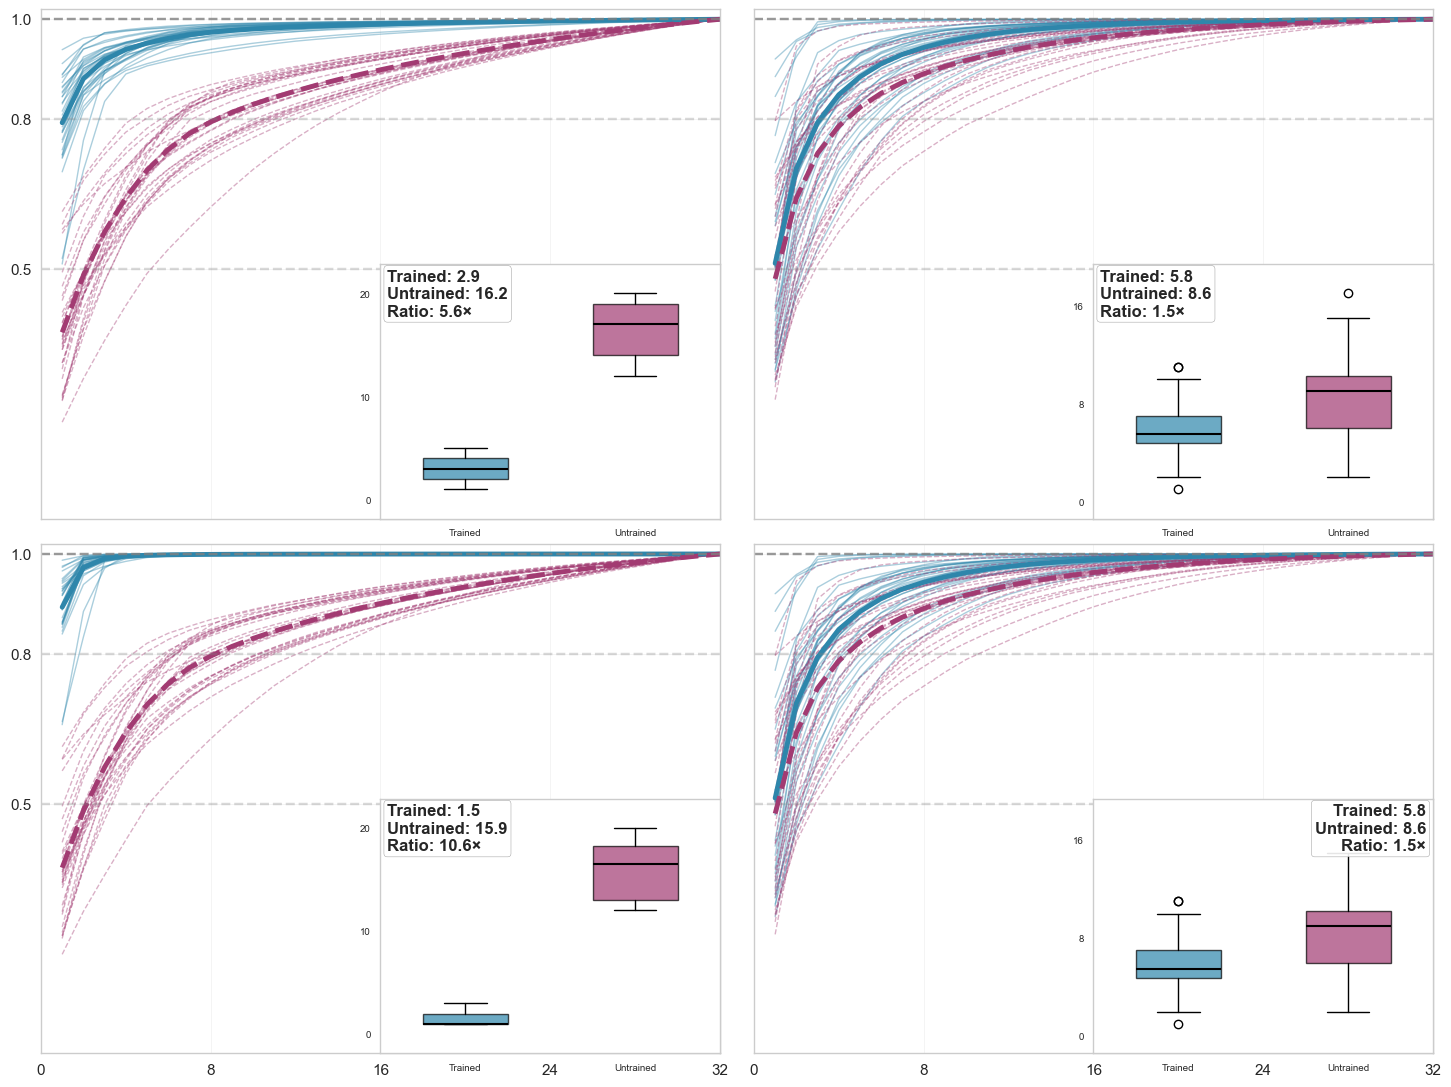

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_four_svd_subplots_compact(learned_svd, learning_svd, grad_svd_learned, grad_svd_random,
                                  learned_svd_lora, learning_svd_lora, grad_learned_svd_lora, 
                                  grad_learning_svd_lora, figsize=(16, 12), save_path='four_svd_comparison_compact.png'):
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    subplot_configs = [{
        'data': (learned_svd, learning_svd),
        'title': 'LoRA A - Activation Values',
        'ax': axes[0, 0], 
        'position': (0, 0)
    }, {
        'data': (grad_svd_learned, grad_svd_random),
        'title': 'LoRA A - Gradient Values',
        'ax': axes[0, 1],
        'position': (0, 1)
    }, {
        'data': (learned_svd_lora, learning_svd_lora), 
        'title': 'LoRA B - Activation Values',
        'ax': axes[1, 0],
        'position': (1, 0)
    }, {
        'data': (grad_learned_svd_lora, grad_learning_svd_lora),
        'title': 'LoRA B - Gradient Values', 
        'ax': axes[1, 1],
        'position': (1, 1)
    }]
    colors = {'lora': '#2E86AB', 'random': '#A23B72'}
    
    def process_single_subplot(svd_results_lora, svd_results_random, ax, title, position):
        """处理单个子图的绘制"""
        row, col = position
        
        def process_svd_results(results, color, label_prefix, linestyle):
            energies = []
            for i, (_, S) in enumerate(results.items()):
                S = torch.tensor(S) if not isinstance(S, torch.Tensor) else S
                energy = (S**2).cumsum(dim=0) / (S**2).sum()
                energy = energy.detach().cpu().numpy()
                energies.append(energy)
                
                label = f'{label_prefix}' if i == 0 else None
                ax.plot(range(1, len(energy)+1), energy,
                    color=color, alpha=0.4, linewidth=1.0,
                    linestyle=linestyle, label=label)
            return energies
        
        def plot_mean_curve(energies, color, label, linestyle):
            if energies:
                min_len = min(len(e) for e in energies)
                mean = np.mean([e[:min_len] for e in energies], axis=0)
                ax.plot(range(1, len(mean)+1), mean,
                       color=color, linewidth=3.5, alpha=1.0,
                       label=f'{label} (Mean)', linestyle=linestyle,
                       solid_capstyle='round')
                return mean
            return None
        
        all_lora_energies = process_svd_results(svd_results_lora, colors['lora'], 'Trained LoRA', '-')
        all_random_energies = process_svd_results(svd_results_random, colors['random'], 'Untrained LoRA', '--')
        
        lora_mean = plot_mean_curve(all_lora_energies, colors['lora'], 'Trained LoRA', '-')
        random_mean = plot_mean_curve(all_random_energies, colors['random'], 'Untrained LoRA', '--')
        
        ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        ax.set_ylim(0, 1.02)
        ax.tick_params(axis='both', labelsize=11)
        
        if row == 0: 
            ax.set_xticks(list(range(0, 33, 8)))
            ax.set_xticklabels([])
        else:  
            ax.set_xticks(list(range(0, 33, 8)))
        
        if col == 1:  
            ax.set_yticks([0.5, 0.8, 1.0])
            ax.set_yticklabels([])
        else:  
            ax.set_yticks([0.5, 0.8, 1.0])
            ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
        
        ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.8)
        for y in [0.5, 0.8]:
            ax.axhline(y=y, color='gray', linestyle='--', alpha=0.3)
        
        ax.set_xlim(0, 32)
        
        def get_sv_90(energies):
            return [np.where(e >= 0.9)[0][0] + 1 for e in energies if len(np.where(e >= 0.9)[0]) > 0]
        
        lora_sv_90 = get_sv_90(all_lora_energies)
        random_sv_90 = get_sv_90(all_random_energies)
        
        ax_stats = ax.inset_axes([0.5, 0.0, 0.5, 0.5])
        box_data = [lora_sv_90, random_sv_90]
        
        bp = ax_stats.boxplot(box_data, tick_labels=['Trained', 'Untrained'], patch_artist=True,
                             boxprops=dict(linewidth=1.0),
                             medianprops=dict(color='black', linewidth=1.5),
                             whiskerprops=dict(linewidth=1.0),
                             capprops=dict(linewidth=1.0),
                             widths=0.5,
                             positions=[0.7, 1.7])  
        
        for i, color in enumerate([colors['lora'], colors['random']]):
            bp['boxes'][i].set_facecolor(color)
            bp['boxes'][i].set_alpha(0.7)
        
        if lora_sv_90 and random_sv_90:
            y_min = min(min(lora_sv_90), min(random_sv_90))
            y_max = max(max(lora_sv_90), max(random_sv_90))
            padding = (y_max - y_min) * 0.15
            ax_stats.set_ylim(y_min - padding, y_max + padding)
        
        ax_stats.set_xlim(0.2, 2.2)
        ax_stats.tick_params(labelsize=7)
        ax_stats.grid(False)
        ax_stats.yaxis.set_major_locator(plt.MaxNLocator(3))
        
        if lora_sv_90 and random_sv_90:
            stats = {
                'lora_mean': np.mean(lora_sv_90),
                'random_mean': np.mean(random_sv_90)
            }
            stats_text = (f"Trained: {stats['lora_mean']:.1f}\n"
                         f"Untrained: {stats['random_mean']:.1f}\n"
                         f"Ratio: {stats['random_mean']/stats['lora_mean']:.1f}×")
            if position == (1, 1): 
                ax_stats.text(0.98, 0.98, stats_text, transform=ax_stats.transAxes,
                            fontsize=12, verticalalignment='top', 
                            horizontalalignment='right', fontweight='bold',
                            bbox=dict(boxstyle='round,pad=0.2', facecolor='white',
                                    alpha=0.9, edgecolor='gray'))
            else:  
                ax_stats.text(0.02, 0.98, stats_text, transform=ax_stats.transAxes,
                            fontsize=12, verticalalignment='top',
                            horizontalalignment='left', fontweight='bold', 
                            bbox=dict(boxstyle='round,pad=0.2', facecolor='white',
                                    alpha=0.9, edgecolor='gray'))
    
    for config in subplot_configs:
        svd_lora, svd_random = config['data']
        process_single_subplot(svd_lora, svd_random, config['ax'], config['title'], config['position'])
    
    handles, labels = axes[0, 0].get_legend_handles_labels()
    
    legend_fig = plt.figure(figsize=(8, 1))
    legend_fig.legend(handles, labels, loc='center', ncol=1, 
                     fontsize=11, framealpha=0.95, fancybox=True, 
                     shadow=True, title_fontsize=12)
    
    legend_fig.savefig('legend.png', dpi=300, bbox_inches='tight', 
                      facecolor='white', edgecolor='none')
    plt.close(legend_fig)
    

    plt.tight_layout()
    plt.subplots_adjust(left=0.08, bottom=0.08, top=0.95, right=0.95, hspace=0.05, wspace=0.05)

    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()
    
    return fig, axes

fig, axes = plot_four_svd_subplots_compact(
    learned_svd, random_svd,
    learned_grad_svd, random_grad_svd, 
    learned_svd_lora, random_svd_lora,
    learned_grad_svd, random_grad_svd,
    save_path='four_svd_comparison_compact.png'
)

In [21]:
selected_layers = [0, 7, 15, 23, 31]
lora_layers = [f"encoder.layers.{i}.self_attn.v_proj" for i in selected_layers]

def get_rank_activations(nmodel, test_data, lora_layers):
    device = nmodel.device
    all_rank = []
    
    for sample_idx, sample in tqdm(enumerate(test_data), desc="Extracting activations"):
        input_features = processor(
            sample['audio'],
            sampling_rate=16000,
            return_tensors="pt"
        ).input_features.to(device)
        
        rank = []
        with torch.no_grad():
            with nmodel.trace(input_features) as tracer:
                for layer_name in lora_layers:
                    activation = nmodel.get(f'{layer_name}.lora_A.default.output').clone().detach().cpu().save()
                    rank.append(activation)
        
        rank = torch.stack(rank, dim=0)
        all_rank.append(rank)
    
    return torch.stack(all_rank, dim=0)

# Extract rank activations
print("Extracting rank-8 activations...")
lora8_rank = get_rank_activations(lora8_model, test_data, lora_layers)

print("Extracting rank-32 activations...")
lora32_rank = get_rank_activations(lora32_model, test_data, lora_layers)

print("Extracting rank-64 activations...")
lora64_rank = get_rank_activations(lora64_model, test_data, lora_layers)

print(f"Rank shapes - 8: {lora8_rank.shape}, 32: {lora32_rank.shape}, 64: {lora64_rank.shape}")

Extracting rank-8 activations...


Extracting activations: 507it [01:16,  6.62it/s]


Extracting rank-32 activations...


Extracting activations: 507it [01:17,  6.54it/s]


Extracting rank-64 activations...


Extracting activations: 507it [01:16,  6.60it/s]


Rank shapes - 8: torch.Size([507, 5, 1, 1500, 8]), 32: torch.Size([507, 5, 1, 1500, 32]), 64: torch.Size([507, 5, 1, 1500, 64])


In [22]:
def center_kernel_matrix_torch(K):
    n = K.shape[0]
    unit = torch.ones(n, n, device=K.device, dtype=K.dtype) / n
    return K - unit @ K - K @ unit + unit @ K @ unit

def center_kernel_matrix_numpy(K):
    n = K.shape[0]
    row_mean = K.mean(axis=1, keepdims=True)
    col_mean = K.mean(axis=0, keepdims=True) 
    total_mean = K.mean()
    return K - row_mean - col_mean + total_mean

def linear_cka_torch(X, Y):
    if X.device != Y.device:
        Y = Y.to(X.device)
    
    K = X @ X.T
    L = Y @ Y.T
    
    K_centered = center_kernel_matrix_torch(K)
    L_centered = center_kernel_matrix_torch(L)
    
    hsic = torch.sum(K_centered * L_centered)
    norm_k = torch.sqrt(torch.sum(K_centered * K_centered))
    norm_l = torch.sqrt(torch.sum(L_centered * L_centered))
    
    if norm_k == 0 or norm_l == 0:
        return torch.tensor(0.0, device=X.device)
    
    return (hsic / (norm_k * norm_l)).cpu().item()

def linear_cka_numpy(X, Y):
    K = X @ X.T
    L = Y @ Y.T
    
    K_centered = center_kernel_matrix_numpy(K)
    L_centered = center_kernel_matrix_numpy(L)
    hsic = np.sum(K_centered * L_centered)
    norm_k = np.sqrt(np.sum(K_centered * K_centered))
    norm_l = np.sqrt(np.sum(L_centered * L_centered))
    
    if norm_k == 0 or norm_l == 0:
        return 0.0
    
    return hsic / (norm_k * norm_l)

def cka_rbf_numpy(X, Y):
    K_X = rbf_kernel(X)
    K_Y = rbf_kernel(Y)
    
    K_X_centered = center_kernel_matrix_numpy(K_X)
    K_Y_centered = center_kernel_matrix_numpy(K_Y)
    hsic = np.sum(K_X_centered * K_Y_centered)
    
    norm_x = np.sqrt(np.sum(K_X_centered * K_X_centered))
    norm_y = np.sqrt(np.sum(K_Y_centered * K_Y_centered))
    
    if norm_x == 0 or norm_y == 0:
        return 0.0
    
    return hsic / (norm_x * norm_y)

def cka(X, Y, kernel_type='linear'):
    if isinstance(X, torch.Tensor) and isinstance(Y, torch.Tensor):
        if kernel_type == 'linear':
            return linear_cka_torch(X, Y)
        else:
            X_np = X.detach().cpu().numpy()
            Y_np = Y.detach().cpu().numpy()
            return cka_rbf_numpy(X_np, Y_np)
    
    elif isinstance(X, torch.Tensor):
        X = X.detach().cpu().numpy()
        
    elif isinstance(Y, torch.Tensor):
        Y = Y.detach().cpu().numpy()
    
    if kernel_type == 'linear':
        return linear_cka_numpy(X, Y)
    else:
        return cka_rbf_numpy(X, Y)

def layer_wise_cka_analysis(activations1, activations2, kernel_type='linear'):
    layer_similarities = {}
    for layer_name in activations1.keys():
        act1 = activations1[layer_name] 
        act2 = activations2[layer_name]
        
        # 重塑为 (samples, features)
        act1_reshape = act1.reshape(act1.shape[0], -1)
        act2_reshape = act2.reshape(act2.shape[0], -1)
        
        similarity = cka(act1_reshape, act2_reshape, kernel_type=kernel_type)
        layer_similarities[layer_name] = similarity
    
    return layer_similarities

def plot_cka_comparison(learned_similarities, random_similarities):
    layers = list(learned_similarities.keys())
    learned_values = [learned_similarities[layer] for layer in layers]
    random_values = [random_similarities[layer] for layer in layers]
    

    layer_indices = []
    for layer in layers:
        try:
            layer_idx = int(layer.split('.')[2])
            layer_indices.append(layer_idx)
        except:
            layer_indices.append(0)
    
    sorted_data = sorted(zip(layer_indices, learned_values, random_values))
    layer_indices, learned_values, random_values = zip(*sorted_data)
    
    plt.figure(figsize=(12, 6))
    x_pos = range(len(layers))
    
    plt.plot(x_pos, learned_values, 'o-', label='Trained LoRA', 
             linewidth=3, markersize=8, color='#2E86AB', alpha=0.8)
    plt.plot(x_pos, random_values, 's--', label='Untrained LoRA', 
             linewidth=3, markersize=8, color='#F24236', alpha=0.8)
    
    plt.fill_between(x_pos, learned_values, random_values, 
                     alpha=0.2, color='gray')
    
    plt.xlabel('Layer Index', fontsize=12)
    plt.ylabel('CKA Similarity', fontsize=12)
    plt.title('Layer-wise CKA: Trained vs Untrained LoRA', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    
    plt.xticks(x_pos[::max(1, len(x_pos)//15)], 
               [f'L{idx}' for idx in layer_indices[::max(1, len(x_pos)//15)]], 
               rotation=45)
    
    plt.tight_layout()
    plt.show()

In [23]:

print("Computing CKA similarities...")

learned_layer_similarities = layer_wise_cka_analysis(
    learned_rank, random_rank, kernel_type='linear'
)
random_layer_similarities = layer_wise_cka_analysis(
    learned_lora, random_lora, kernel_type='rbf'
)
learned_layer_grad_similarities = layer_wise_cka_analysis(
    learned_lora_grad, learned_rank_grad, kernel_type='rbf'
)
random_layer_grad_similarities = layer_wise_cka_analysis(
    random_lora_grad, random_rank_grad, kernel_type='rbf'
)


Computing CKA similarities...


In [24]:
def layer_comparison_academic(learned_similarities, learning_similarities, 
                            learned_grad_similarities, learning_grad_similarities):

    import matplotlib.pyplot as plt
    import numpy as np
    
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['DejaVu Serif', 'Liberation Serif', 'serif'],
        'font.size': 10,
        'axes.linewidth': 0.8,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.2,
        'patch.linewidth': 0.5,
        'xtick.major.width': 0.8,
        'ytick.major.width': 0.8,
        'xtick.minor.width': 0.6,
        'ytick.minor.width': 0.6,
        'axes.edgecolor': 'black',
        'axes.grid': True,
        'grid.alpha': 0.3
    })
    
    layers = list(learned_similarities.keys())
    learned_values = [learned_similarities[layer] for layer in layers]
    learning_values = [learning_similarities[layer] for layer in layers]
    learned_grad_values = [learned_grad_similarities[layer] for layer in layers]
    learning_grad_values = [learning_grad_similarities[layer] for layer in layers]
    
    layer_indices = []
    for layer in layers:
        try:
            layer_idx = int(layer.split('.')[2])
            layer_indices.append(layer_idx)
        except:
            layer_indices.append(0)
    
    sorted_data = sorted(zip(layer_indices, learned_values, learning_values, 
                           learned_grad_values, learning_grad_values))
    layer_indices, learned_values, learning_values, learned_grad_values, learning_grad_values = zip(*sorted_data)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 8))
    x_pos = np.arange(len(layers))
    
    ax1.plot(x_pos, learned_values, 'o-', label='Trained', 
             linewidth=1.5, markersize=3.5, color='#2E2E2E', markerfacecolor='black')
    ax1.plot(x_pos, learning_values, 's--', label='Untrained', 
             linewidth=1.2, markersize=3.5, color='#808080', markerfacecolor='gray', alpha=0.8)
    
    ax1.fill_between(x_pos, learned_values, learning_values, 
                     alpha=0.12, color='lightgray')
    
    legend1 = ax1.legend(fontsize=10, frameon=True, fancybox=False, shadow=False, 
                        framealpha=0.9, edgecolor='black')
    legend1.get_frame().set_linewidth(0.8)
    ax1.grid(True, alpha=0.25, linestyle='-', linewidth=0.5)
    ax1.set_ylim(0.82, 1.005)
    
    ax1.set_yticks([0.85, 0.92, 0.99])
    
    ax2.plot(x_pos, learned_grad_values, '^-', label='Trained', 
             linewidth=1.5, markersize=3.5, color='#2E2E2E', markerfacecolor='black')
    ax2.plot(x_pos, learning_grad_values, 'v--', label='Untrained', 
             linewidth=1.2, markersize=3.5, color='#808080', markerfacecolor='gray', alpha=0.8)
    
    ax2.fill_between(x_pos, learned_grad_values, learning_grad_values, 
                     alpha=0.12, color='lightgray')
    
    legend2 = ax2.legend(fontsize=10, frameon=True, fancybox=False, shadow=False,
                        framealpha=0.9, edgecolor='black')
    legend2.get_frame().set_linewidth(0.8)
    ax2.grid(True, alpha=0.25, linestyle='-', linewidth=0.5)
    ax2.set_ylim(-0.8, 1.05)
    
    ax2.set_yticks([-0.5, 0.25, 1.0])
    
    # 统一设置X轴
    for ax in [ax1, ax2]:
        tick_positions = x_pos[::7]  
        ax.set_xticks(tick_positions)
        ax.set_xticklabels([f'{layer_indices[i]}' for i in tick_positions], 
                          fontsize=9)
        ax.set_xlim(-0.5, len(layers)-0.5) 
        
        ax.tick_params(axis='both', which='major', labelsize=9, 
                      direction='in', length=4, width=0.8)
        ax.tick_params(axis='both', which='minor', direction='in', 
                      length=2, width=0.6)
        
        for spine in ax.spines.values():
            spine.set_linewidth(0.8)
            spine.set_color('black')
    
    plt.tight_layout(pad=2.0, w_pad=3.0)
    
    plt.savefig('cka_academic_style.png', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    plt.savefig('cka_academic_style.pdf', bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    
    plt.show()
    
    plt.rcdefaults()

In [25]:
# Define layers for analysis (selected layers)
selected_layers = [0, 7, 15, 23, 31]
lora_layers = [f"encoder.layers.{i}.self_attn.v_proj" for i in selected_layers]

def get_rank_activations(nmodel, test_data, lora_layers):
    device = nmodel.device
    all_rank = []
    
    for sample_idx, sample in tqdm(enumerate(test_data), desc="Extracting activations"):
        input_features = processor(
            sample['audio'],
            sampling_rate=16000,
            return_tensors="pt"
        ).input_features.to(device)
        
        rank = []
        with torch.no_grad():
            with nmodel.trace(input_features) as tracer:
                for layer_name in lora_layers:
                    activation = nmodel.get(f'{layer_name}.lora_A.default.output').clone().detach().cpu().save()
                    rank.append(activation)
        
        rank = torch.stack(rank, dim=0)
        all_rank.append(rank)
    
    return torch.stack(all_rank, dim=0)

# Extract rank activations
print("Extracting rank-8 activations...")
lora8_rank = get_rank_activations(lora8_model, test_data, lora_layers)

print("Extracting rank-32 activations...")
lora32_rank = get_rank_activations(lora32_model, test_data, lora_layers)

print("Extracting rank-64 activations...")
lora64_rank = get_rank_activations(lora64_model, test_data, lora_layers)

print(f"Rank shapes - 8: {lora8_rank.shape}, 32: {lora32_rank.shape}, 64: {lora64_rank.shape}")

Extracting rank-8 activations...


Extracting activations: 507it [01:17,  6.57it/s]


Extracting rank-32 activations...


Extracting activations: 507it [01:16,  6.64it/s]


Extracting rank-64 activations...


Extracting activations: 507it [01:16,  6.60it/s]


Rank shapes - 8: torch.Size([507, 5, 1, 1500, 8]), 32: torch.Size([507, 5, 1, 1500, 32]), 64: torch.Size([507, 5, 1, 1500, 64])


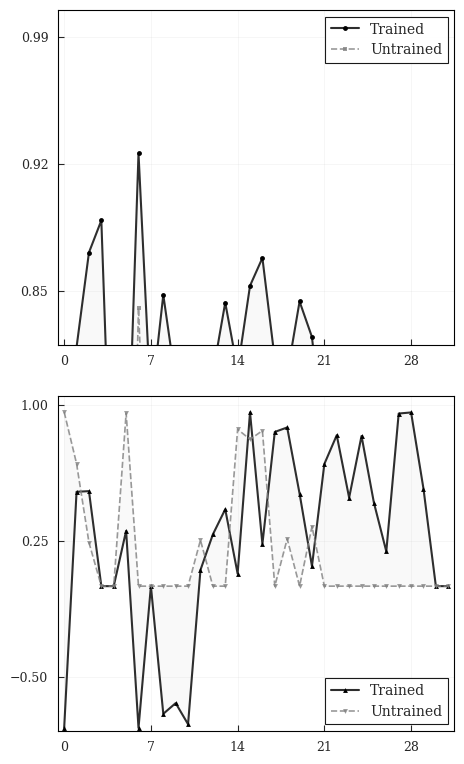

In [26]:
layer_comparison_academic(learned_layer_similarities, random_layer_similarities,
                        learned_layer_grad_similarities, random_layer_grad_similarities)